In [1]:
# enable IE to call matlplotlib
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import *
from fastai.vision import *
from sklearn.model_selection import train_test_split
import requests
import pprint
import os
import json

In [5]:
!mkdir -p ../data

!wget -P ../data https://storage.googleapis.com/np-training-public/datasets/kaggle-dogbreed/dog-breed-identification.zip 
!unzip ../data/dog-breed-identification.zip  -d ../data

--2019-08-11 22:20:07--  https://storage.googleapis.com/np-training-public/datasets/kaggle-dogbreed/dog-breed-identification.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 723322089 (690M) [application/zip]
Saving to: ‘../data/dog-breed-identification.zip’

dog-breed-identific 100%[===================>] 689.81M   201MB/s    in 3.6s    

2019-08-11 22:20:10 (191 MB/s) - ‘../data/dog-breed-identification.zip’ saved [723322089/723322089]

Archive:  ../data/dog-breed-identification.zip
  inflating: ../data/train.zip       
  inflating: ../data/sample_submission.csv  
  inflating: ../data/test.zip        
  inflating: ../data/labels.csv      


In [6]:
!unzip -q ../data/train.zip  -d ../data 
!unzip -q ../data/test.zip  -d ../data

In [7]:
PATH = '../data/'
sz = 224
arch = models.resnet34
bs = 32
!ls {PATH}

dog-breed-identification.zip  sample_submission.csv  test.zip  train.zip
labels.csv		      test		     train


In [8]:
files = os.listdir(f'{PATH}train')[:5]
files

['deb5ab49dab71dea5d3a076f00eb4820.jpg',
 '8f73fe936d2477bdbef77ebb0deaef78.jpg',
 '3cab06b69e8404ed0f90144ee4ef5271.jpg',
 '5a73316d885b4b6e4d9845100f762e4c.jpg',
 '5406eeabc4f6b981cc6f61cc7a335eae.jpg']

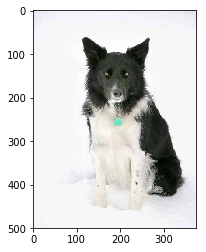

In [9]:
img = plt.imread(f'{PATH}train/{files[0]}')
plt.imshow(img);

In [10]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1


In [11]:
labels_df = pd.read_csv(label_csv)
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [12]:
label_csv

'../data/labels.csv'

In [13]:
tfms = get_transforms()


In [14]:
num_workers = 8
#size = 128

In [15]:
def get_data(size=64,bs=32,num_workers=8,valid_pct=0.2,tfms=tfms):
    data = ImageDataBunch.from_csv(path=PATH, folder='train', csv_labels='labels.csv', bs=bs, ds_tfms=tfms,  
                            suffix='.jpg', valid_pct=valid_pct, num_workers=num_workers, size=size).normalize(imagenet_stats)
    
    return  data

In [16]:
data = get_data(64)

In [17]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier',
  'appenzeller',
  'australian_terrier',
  'basenji',
  'basset',
  'beagle',
  'bedlington_terrier',
  'bernese_mountain_dog',
  'black-and-tan_coonhound',
  'blenheim_spaniel',
  'bloodhound',
  'bluetick',
  'border_collie',
  'border_terrier',
  'borzoi',
  'boston_bull',
  'bouvier_des_flandres',
  'boxer',
  'brabancon_griffon',
  'briard',
  'brittany_spaniel',
  'bull_mastiff',
  'cairn',
  'cardigan',
  'chesapeake_bay_retriever',
  'chihuahua',
  'chow',
  'clumber',
  'cocker_spaniel',
  'collie',
  'curly-coated_retriever',
  'dandie_dinmont',
  'dhole',
  'dingo',
  'doberman',
  'english_foxhound',
  'english_setter',
  'english_springer',
  'entlebucher',
  'eskimo_dog',
  'flat-coated_retriever',
  'french_bulldog',
  'german_shepherd',
  'german_short-haired_pointer',
  'giant_schnauzer',
  'golden_retriever',
  'gordon_setter',
  'great_dane',
  'great_pyren

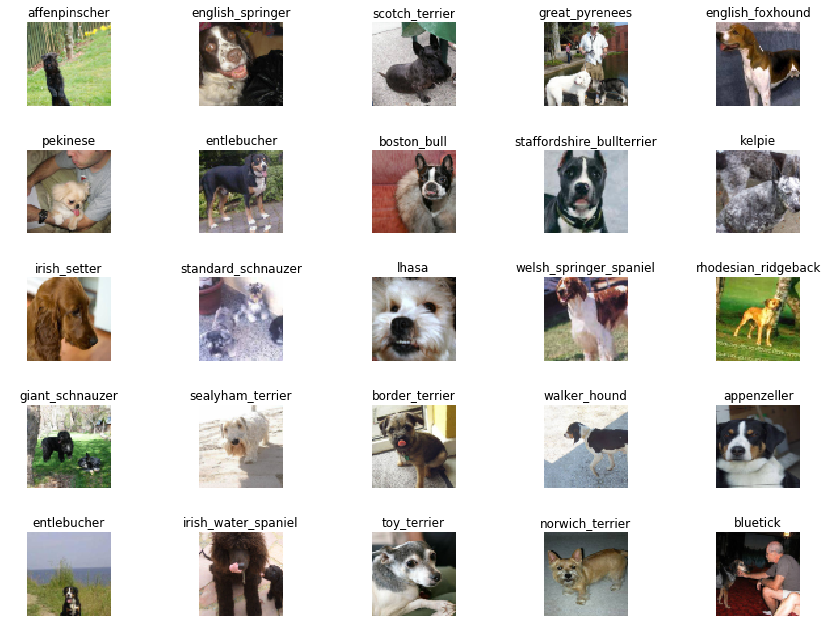

In [18]:
data.show_batch(rows=5, figsize=(12, 9))


In [19]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy],pretrained=True)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


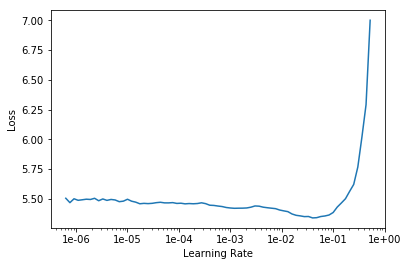

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
lr = 1e-2


In [22]:
learn.fit_one_cycle(6 , lr)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.296898,3.804208,0.866928,0.133072,00:18
1,3.682327,3.407083,0.818982,0.181018,00:18
2,3.351364,3.131271,0.772505,0.227495,00:17
3,3.055326,2.793579,0.714286,0.285714,00:18
4,2.673247,2.526686,0.653131,0.346869,00:18
5,2.503521,2.464330,0.641389,0.358611,00:18


In [23]:
learn.save(f'stage-1')


In [24]:
data = get_data(128)

In [25]:
learn.data = data


In [26]:
learn.fit_one_cycle(6 , lr)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.899088,1.596688,0.459883,0.540117,00:26
1,2.175676,2.071113,0.565558,0.434442,00:26
2,2.022569,1.693482,0.497554,0.502446,00:26
3,1.702234,1.373844,0.390900,0.609100,00:26
4,1.445454,1.213899,0.355675,0.644325,00:26
5,1.240573,1.170420,0.343444,0.656556,00:26


In [27]:
learn.save(f'stage-2')


In [28]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


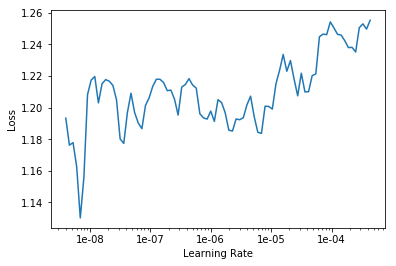

In [29]:
learn.lr_find(start_lr=1e-09, end_lr=1e-3)
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, max_lr=slice(1e-8,1e-4))

learn.save('stage-3')

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.239224,1.174741,0.344423,0.655577,00:27
1,1.158854,1.160222,0.347847,0.652153,00:27
2,1.187920,1.154938,0.337084,0.662916,00:27
3,1.243933,1.156469,0.336106,0.663894,00:27
4,1.155829,1.155928,0.341977,0.658023,00:27


In [31]:
learn.freeze()

In [32]:
learn.data = get_data(224)


In [33]:
learn.fit_one_cycle(5, lr)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.150737,1.058543,0.333659,0.666341,00:29
1,1.438159,1.106550,0.345890,0.654110,00:29
2,1.231790,0.842825,0.260274,0.739726,00:29
3,0.913069,0.693570,0.220646,0.779354,00:29
4,0.726441,0.647284,0.207436,0.792564,00:29


In [34]:
learn.save('stage-4')

In [35]:
learn.load(f'stage-4');


In [36]:
interp = ClassificationInterpretation.from_learner(learn)


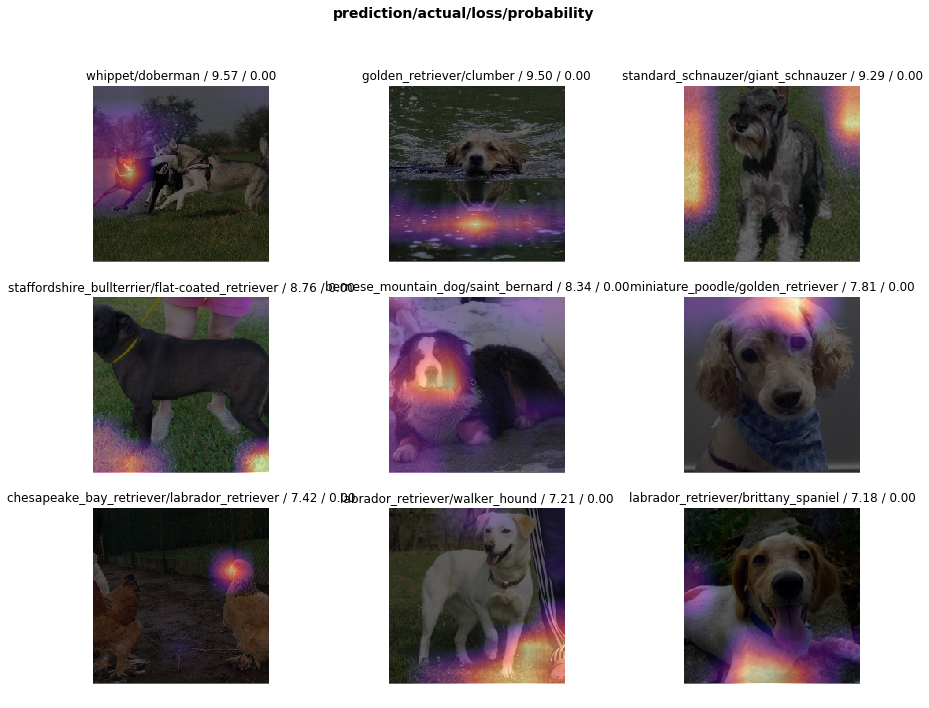

In [37]:
interp.plot_top_losses(9, figsize=(15,11))


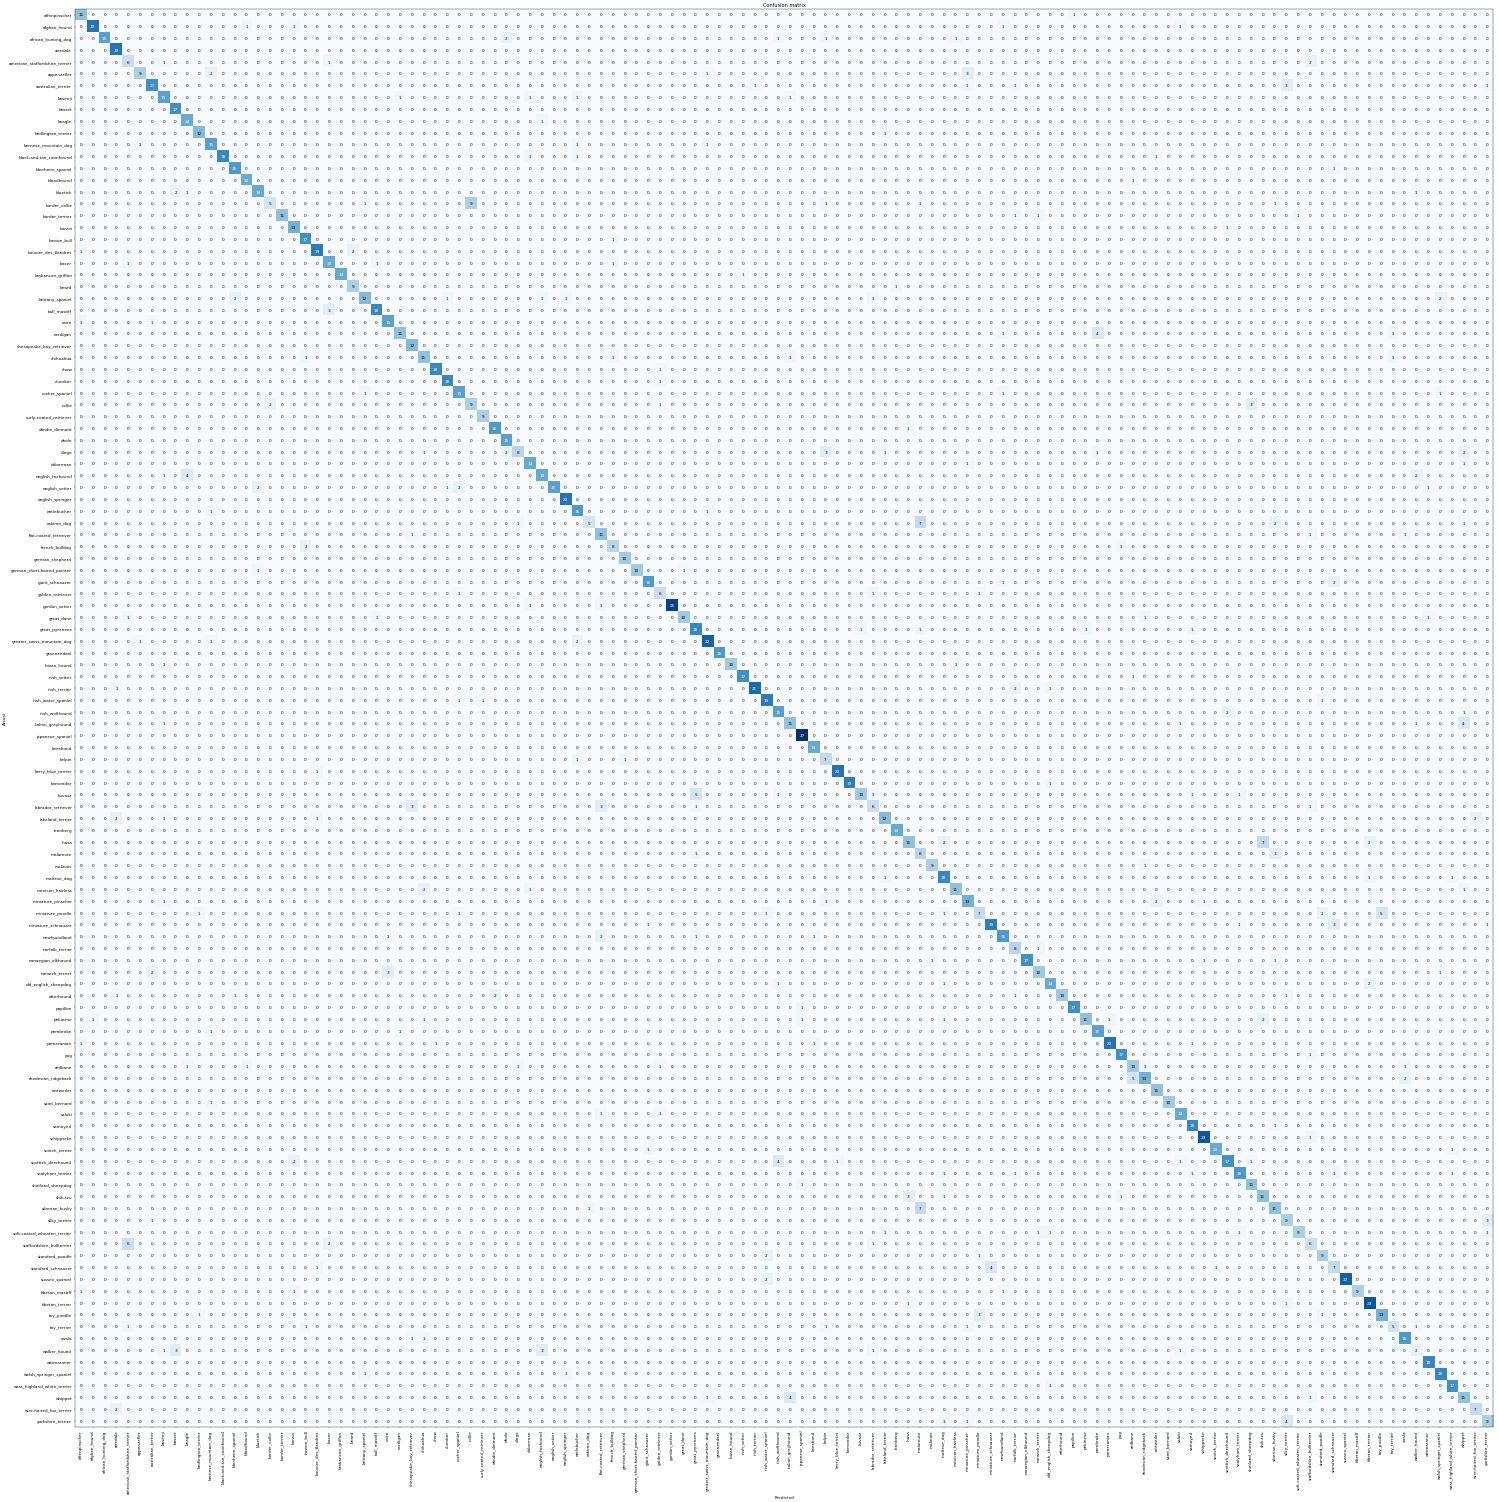

In [38]:
interp.plot_confusion_matrix(figsize=(50,50), dpi=30)


In [39]:
interp.most_confused(min_val=2)


[('border_collie', 'collie', 9),
 ('eskimo_dog', 'malamute', 7),
 ('lhasa', 'shih-tzu', 7),
 ('siberian_husky', 'malamute', 7),
 ('staffordshire_bullterrier', 'american_staffordshire_terrier', 6),
 ('kuvasz', 'great_pyrenees', 5),
 ('miniature_poodle', 'toy_poodle', 5),
 ('rhodesian_ridgeback', 'redbone', 5),
 ('cardigan', 'pembroke', 4),
 ('english_foxhound', 'beagle', 4),
 ('italian_greyhound', 'whippet', 4),
 ('scottish_deerhound', 'irish_wolfhound', 4),
 ('standard_schnauzer', 'miniature_schnauzer', 4),
 ('whippet', 'italian_greyhound', 4),
 ('yorkshire_terrier', 'silky_terrier', 4),
 ('appenzeller', 'miniature_pinscher', 3),
 ('australian_terrier', 'silky_terrier', 3),
 ('bull_mastiff', 'boxer', 3),
 ('collie', 'shetland_sheepdog', 3),
 ('dingo', 'kelpie', 3),
 ('labrador_retriever', 'chesapeake_bay_retriever', 3),
 ('labrador_retriever', 'flat-coated_retriever', 3),
 ('malamute', 'siberian_husky', 3),
 ('miniature_schnauzer', 'standard_schnauzer', 3),
 ('norwich_terrier', 'cairn'

In [40]:
def fetch_image(url):
    response = requests.get(url)
    img = open_image(BytesIO(response.content))
    return img

def predict(url):
    img = fetch_image(url)
    
    pred_class,pred_idx,outputs = learn.predict(img)
    res =  zip (learn.data.classes, outputs.tolist())
    predictions = sorted(res, key=lambda x:x[1], reverse=True)
    top_predictions = predictions[0:5]
    
    pprint.pprint( top_predictions)
    
    return img.resize(224)

In [41]:
img_chihuahua = "https://upload.wikimedia.org/wikipedia/commons/4/4c/Chihuahua1_bvdb.jpg"


[('chihuahua', 0.41057515144348145),
 ('papillon', 0.20787379145622253),
 ('pomeranian', 0.11142563074827194),
 ('brabancon_griffon', 0.09871867299079895),
 ('yorkshire_terrier', 0.03340987488627434)]


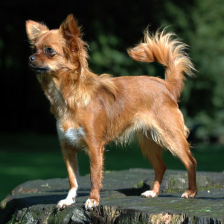

In [42]:
predict(img_chihuahua)

In [43]:
img_poodle = "https://upload.wikimedia.org/wikipedia/commons/f/f8/Full_attention_%288067543690%29.jpg"

[('standard_poodle', 0.9620255827903748),
 ('miniature_poodle', 0.03227713704109192),
 ('curly-coated_retriever', 0.0026243715547025204),
 ('toy_poodle', 0.0019728161860257387),
 ('irish_water_spaniel', 0.0009640206699259579)]


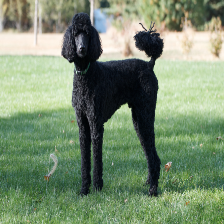

In [44]:
predict(img_poodle)

# Export

In [50]:
shutil.rmtree("../models",ignore_errors=True)
os.makedirs("../models")

In [53]:
final_model_directory = os.getcwd()+ "/../models"
final_model_name='model.pkl'

In [54]:
learn.export(final_model_directory+f"/{final_model_name}")


In [55]:
learn.data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [49]:
with open('../models/classes.txt', 'w') as f:
    json.dump(learn.data.classes,f)

# Load

In [56]:
learn3= load_learner(final_model_directory,final_model_name)


In [57]:
img = fetch_image(img_poodle)
learn3.predict(img)


(Category standard_poodle,
 tensor(105),
 tensor([4.5826e-07, 3.0212e-06, 2.9692e-10, 1.1705e-07, 2.0067e-09, 1.3170e-09,
         9.0079e-10, 7.3529e-08, 3.5518e-09, 5.4146e-11, 4.6484e-06, 1.1077e-09,
         3.6633e-07, 2.4221e-08, 3.9830e-09, 4.6230e-06, 6.1012e-10, 1.8125e-10,
         3.9916e-09, 7.5854e-10, 1.0447e-06, 1.4125e-10, 7.9669e-09, 5.0672e-10,
         8.6694e-08, 1.7042e-09, 8.3391e-10, 6.6981e-11, 4.5765e-09, 2.5117e-09,
         7.1835e-09, 3.8399e-08, 6.8224e-07, 3.8821e-08, 2.6244e-03, 4.9562e-10,
         1.6568e-09, 6.1409e-09, 2.9767e-09, 3.2713e-08, 4.0042e-06, 1.3719e-06,
         5.4102e-10, 1.1569e-09, 1.1914e-05, 3.0019e-08, 1.1458e-09, 9.1805e-07,
         1.7899e-07, 8.6252e-10, 5.3207e-06, 1.2348e-07, 4.5975e-10, 1.6915e-11,
         2.2856e-06, 5.2882e-10, 5.2867e-08, 1.0260e-09, 9.6402e-04, 1.9699e-10,
         1.0516e-07, 2.1041e-07, 1.0230e-08, 1.3763e-07, 8.7817e-05, 6.9714e-08,
         6.9926e-08, 1.7906e-08, 1.0841e-07, 1.9957e-09, 3.5434e-09,

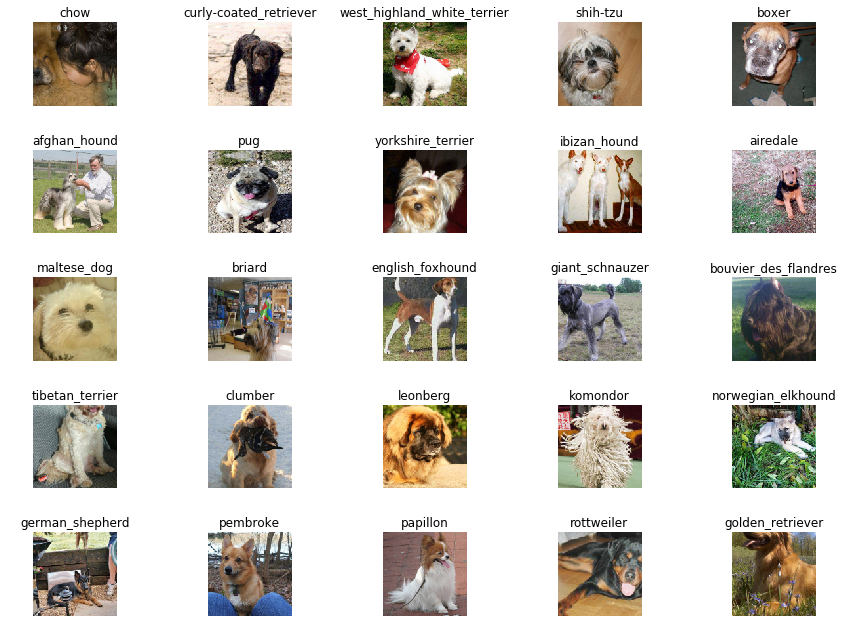

In [59]:
i2 =data.show_batch(rows=5, figsize=(12, 9))


In [62]:
?data.show_batch

Signature:
data.show_batch(
    rows: int = 5,
    ds_type: fastai.basic_data.DatasetType = <DatasetType.Train: 1>,
    reverse: bool = False,
    **kwargs,
) -> None
Docstring: Show a batch of data in `ds_type` on a few `rows`.
File:      /opt/anaconda3/lib/python3.7/site-packages/fastai/basic_data.py
Type:      method
